# Tuning MCTS params to support policy training

We are using the Upper Confidence Bound for MCTS

$$
U(s, a) = Q(s, a) + c_{puct} P(s, a) \frac{\sqrt{\sum_b N(s, b)}}{1 + N(s, a)}
$$

In [1]:
import copy
import copyreg
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from tqdm import tqdm

from aegomoku.gomoku_board import GomokuBoard
from aegomoku.gomoku_game import ConstantBoardInitializer, GomokuGame as Game
from aegomoku.interfaces import MctsParams, PolicyAdviser, PolicyParams
from aegomoku.mcts import MCTS
from aegomoku.gomoku_players import PolicyAdvisedGraphSearchPlayer
from aegomoku.policies.topological_value import TopologicalValuePolicy
from aegomoku.utils import analyse_board

In [3]:
BOARD_SIZE=19


---
# The Anomaly
The current position demands mitigating the threat on H11 by either of E11, H11, or J11. However, after 1000 simulations, H13 is slightly preferred and will be selected at temp=0.
Interesting enough: the previous champion does select the most obvious defensive move H11.

It was believed that in these kind of clear positions, the PAGS would overwrite initial recommendations correctly, if the original estimate at least contains the better recommendation.

In [67]:
from aegomoku.gomoku_game import GomokuGame
stones = "G11G13G12H12I11F13F11"
initializer = ConstantBoardInitializer(stones)
ai = "2_c1.model"
ai = "3_c2.model"
policy = PolicyParams(model_file_name=f"../DATA/models/{ai}", advice_cutoff=.01)
game = GomokuGame(board_size=BOARD_SIZE, initializer=initializer)
mcts_params = MctsParams(cpuct=1.0, temperature=0.0, num_simulations=1000)
player = PolicyAdvisedGraphSearchPlayer("Policy-advised graph search", game, mcts_params, policy)
board = game.get_initial_board()

In [68]:
p = player.mcts.get_action_prob(board, temperature=0.)

In [69]:
np.where(np.array(p) == 1.0)

(array([159]),)

In [70]:
board.Stone(159)

H11

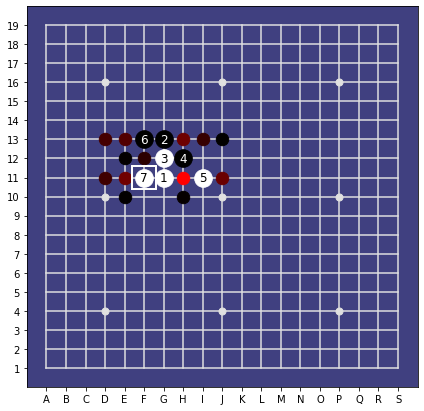

In [38]:
#policy = TopologicalValuePolicy(kappa_s=6, kappa_d=5)
analyse_board(BOARD_SIZE, stones, player.advisor.model, disp_width=7, policy_cutoff=.01)

In [40]:
s = board.get_string_representation()

In [43]:
player.mcts.Nsa[(s, 159)]

206

In [47]:
import copy
next_board = copy.deepcopy(board).act(121)
next_board.plot()

                                                                 
19    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
18    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
17    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
16    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  O  O [O] .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  X  O  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  .  .  .  X  X  .  X  .  .  .  .  .  .  .  .  .  .    
10    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 9    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 8    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 7    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 6    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 5    .  .

In [58]:
next_state = next_board.canonical_representation()
next_key = next_board.get_string_representation()

In [55]:
p, v = player.advisor.evaluate(next_state)

array(0.46831572, dtype=float32)

In [60]:
visits = [player.mcts.Nsa.get((next_key, x), 0) for x in range(361)]
print(visits)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 8, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 246, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [63]:
board.Stone(np.where(np.array(visits) > 100)[0][0])

H11

In [64]:
crit_board = copy.deepcopy(next_board).act(159)
crit_board.plot()

                                                                 
19    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
18    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
17    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
16    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  O  O  O  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  X  O  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  .  .  .  X  X [X] X  .  .  .  .  .  .  .  .  .  .    
10    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 9    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 8    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 7    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 6    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 5    .  .

In [65]:
next_state = crit_board.canonical_representation()
next_key = crit_board.get_string_representation()

In [66]:
p, v = player.advisor.evaluate(next_state)
v

array(-0.5234637, dtype=float32)